### CREDENTIALS

In [1]:
IG_LINK = 'https://www.instagram.com/'

USERNAME = input('Enter your Ig Handle: ')
PASSWORD = input('Enter your Ig Password: ')

Enter your Ig Handle: 9anubhavtyagi
Enter your Ig Password: GAX@instagram-9


### Module Imports

In [2]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from selenium.webdriver.support.select import Select
from selenium.common import exceptions as SCE

import time

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import emoji

### Start Session

In [5]:
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

driver.maximize_window()



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\anubh\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache


**wait object** 

In [6]:
wait = WebDriverWait(driver, 10)

### log-in function

In [7]:
def log_in(driver, wait, username, password):
    # visit instagram
    driver.get(IG_LINK)
    time.sleep(3)
    
    # wait until log-in form is loaded -> by checking username box
    wait.until(EC.presence_of_element_located((By.NAME, 'username')))
    
    username_box = driver.find_element(By.NAME, 'username')
    username_box.send_keys(username)
    
    password_box = driver.find_element(By.NAME, 'password')
    password_box.send_keys(password)
    
    password_box.submit()
    time.sleep(3)
    
    
    # avoid save login info
    try:
        # wait until or if save login info option appears
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'y3zKF')))
        ele = driver.find_element(By.CLASS_NAME, 'y3zKF')
        ele.click()
        
    except:
        print('No login info save option appears')
    
    
    time.sleep(2)
    

    # avoid turning on notifications
    try:
        # wait until or if turn-on notifications option appears
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'HoLwm')))
        ele = driver.find_element(By.CLASS_NAME, 'HoLwm')
        ele.click()
        
    except:
        print('No turn-on notifications option appears')


## Log-in Instagram

In [8]:
log_in(driver, wait, USERNAME, PASSWORD)

### loading data from csv that I created in previous notebook

In [9]:
df = pd.read_csv('top5.csv')
df

,Unnamed: 0,handle_name,followers_count,handle_link
0,0,foodie_incarnate,1100000,https://www.instagram.com/foodie_incarnate/
1,1,dilsefoodie,962000,https://www.instagram.com/dilsefoodie/
2,2,foodtalkindia,307000,https://www.instagram.com/foodtalkindia/
3,3,delhifoodwalks,159000,https://www.instagram.com/delhifoodwalks/
4,4,food,158000,https://www.instagram.com/food/


In [10]:
# handles names
handle_names = df['handle_name'].values

# handle links
handle_links = df['handle_link'].values

## Some functions that are required in this notebokk

### function to fetch first 'n' posts link

In [11]:
def get_first_n_post_links(driver, wait, handle_link, n):
    # open link
    driver.get(handle_link)
    time.sleep(3)
    
    # wait until posts are loaded
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="react-root"]/section/main/div/div[3]/article/div[1]/div/div/div/a')))

    # handle page consist 24 posts, so scrolling is mandatory, if more number of posts are required 

    # current height of page
    curr_page_height = driver.execute_script('return document.body.scrollHeight;')

    while True:
        # try to fetch n posts
        ele_list = driver.find_elements(By.XPATH, '//*[@id="react-root"]/section/main/div/div[3]/article/div[1]/div/div/div/a')[:n]

        # break if 30 posts collected
        if len(ele_list) == n:
            break

        # scroll
        driver.execute_script(f'window.scrollTo(0, {curr_page_height});')
        time.sleep(2)

        # new page height
        new_page_height = driver.execute_script('return document.body.scrollHeight;')

        # if current and new heights are same -> break
        if new_page_height == curr_page_height:
            break

        curr_page_height = new_page_height
        
    # list to store links
    links = []

    # extract and store links
    for ele in ele_list:
        links.append(ele.get_attribute('href').strip())
        
    return links


### function to scrap post content

In [12]:
def scrap_post_content(driver, wait, post_link):
    # open link
    driver.get(post_link)
    time.sleep(3)
    
    # wait for post description to be loaded
    wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="react-root"]/section/main/div/div[1]/article/div/div[2]/div/div[2]/div[1]/ul/div/li/div/div/div[2]/span')))
    
    # return post content
    return driver.find_element(By.XPATH, '//*[@id="react-root"]/section/main/div/div[1]/article/div/div[2]/div/div[2]/div[1]/ul/div/li/div/div/div[2]/span').text

### function to clean text

In [13]:
def clean_text(text):
    # remove '\n', ','
    text = text.replace("\n", "")
    text = text.replace(",", "")
    
    # remove emojis
    text = emoji.get_emoji_regexp().sub("", text)
    
    # remove "'", '.'
    text = text.replace("'", " ")
    text = text.replace(".", " ")
    
    return text

# 2.) a. Open the 5 handles you obtained in the last question, and scrape the content of the first 10 posts of each handle.

## extract/scrap content of 10 posts of each food handle

**I am separating hashtags and description in below code from post content** 

In [14]:
total_desc_string = ''

for link in handle_links:
    post_links = get_first_n_post_links(driver, wait, link, 10)
    
    for post_link in post_links:
        # open link
        driver.get(post_link)
        time.sleep(3)

        
        # wait for post description to be loaded
        wait.until(EC.presence_of_element_located((By.XPATH, '//*[@id="react-root"]/section/main/div/div[1]/article/div/div[2]/div/div[2]/div[1]/ul/div/li/div/div/div[2]/span')))
        
        # scrap content
        text =  driver.find_element(By.XPATH, '//*[@id="react-root"]/section/main/div/div[1]/article/div/div[2]/div/div[2]/div[1]/ul/div/li/div/div/div[2]/span').text
        
        # clean text
        text = clean_text(text)
        
        # add text in total_desc_string
        total_desc_string += text
        
        # add '--sep_post--' string to total_desc_string -> so that 'post description' of posts can be distinguished later
        total_desc_string += '--sep_post--'
        
    
    # add '--sep_handle--' string to total_desc_string -> so that 'post description' of handles can be distinguished later
    total_desc_string += '--sep_handle--'


## Printing scraped content

In [15]:
for i in range(5):
    print(f"{handle_names[i]} post content are listed below:-")
    
    handle_post_desc_list = total_desc_string.split('--sep_handle--')
    handle_post_desc = handle_post_desc_list[i]
    
    for i in range(10):
        print(f"Post - {i+1}:", end=' ')
        
        post_desc_list = handle_post_desc.split('--sep_post--')
        post_desc = post_desc_list[i]
        
        print(post_desc)
        print()
        
    print('------------------------------------------------------------------------------------------------------------')
    print()


foodie_incarnate post content are listed below:-
Post - 1: Unique Making of Karachi Halwa Kindly watch the full video for location price & other details #foodieincarnate #sodelhi #newdelhi #foodtalkindia #delhigram #indianfood #delhifoodblogger #foodgasm #foodporn #foodpornshare #foodlover #foodgram #foodiesofinstagram #foodie #indianstreetfood #streetfood #delhistreetfood #streetfoodindia #mumbaistreetfood #delhifoodie #foodblogger #indianfoodie #desikhana #indianfoodblogger #indianfoodbloggers #delhifood #mumbai #delhi #halwa #karachihalwa

Post - 2: HUGE Halwa Paratha of Nagpur Watch the full video on my YouTube channel  Link is in my bio #Foodieincarnate #Reelitfeelit #reelkarofeelkaro #reelsinstagram #reels #paratha #streetfood #viralfood #explore #nagpur

Post - 3: Itna butter kam hai ya zyada?? Delhi Gate Tea Stall Agra #Foodieincarnate #Reelitfeelit #reelkarofeelkaro #reelsinstagram #reels #butter #agra #streetfood #amulbutter #viralvideos #viralfood

Post - 4: Param Da Dhaba s

# 2.) b. Prepare a list of all words used in all the scraped posts and calculate the frequency of each word.

In [16]:
# dictionary to store words and their counts
word_dict = {}

for handle_post_desc in total_desc_string.split('--sep_handle--'):
    for post_desc in handle_post_desc.split('--sep_post--'):
        for word in post_desc.split():
            word_dict[word] = word_dict.get(word, 0) +1

word_dict

{'Unique': 2,
 'Making': 1,
 'of': 33,
 'Karachi': 1,
 'Halwa': 2,
 'Kindly': 4,
 'watch': 5,
 'the': 57,
 'full': 7,
 'video': 6,
 'for': 19,
 'location': 4,
 'price': 4,
 '&': 11,
 'other': 5,
 'details': 6,
 '#foodieincarnate': 6,
 '#sodelhi': 6,
 '#newdelhi': 5,
 '#foodtalkindia': 5,
 '#delhigram': 5,
 '#indianfood': 8,
 '#delhifoodblogger': 6,
 '#foodgasm': 5,
 '#foodporn': 8,
 '#foodpornshare': 5,
 '#foodlover': 6,
 '#foodgram': 5,
 '#foodiesofinstagram': 5,
 '#foodie': 10,
 '#indianstreetfood': 5,
 '#streetfood': 10,
 '#delhistreetfood': 7,
 '#streetfoodindia': 5,
 '#mumbaistreetfood': 5,
 '#delhifoodie': 7,
 '#foodblogger': 6,
 '#indianfoodie': 5,
 '#desikhana': 4,
 '#indianfoodblogger': 5,
 '#indianfoodbloggers': 7,
 '#delhifood': 5,
 '#mumbai': 4,
 '#delhi': 5,
 '#halwa': 1,
 '#karachihalwa': 1,
 'HUGE': 1,
 'Paratha': 1,
 'Nagpur': 1,
 'Watch': 3,
 'on': 13,
 'my': 7,
 'YouTube': 7,
 'channel': 5,
 'Link': 2,
 'is': 14,
 'in': 28,
 'bio': 4,
 '#Foodieincarnate': 4,
 '#Reelit

# 2.) c. Create a csv file with two columns : the word and its frequency

In [17]:
# extract words and their counts in list
words = list(word_dict.keys())
count = list(word_dict.values())

## store in csv

In [18]:
word_df = pd.DataFrame({
    "words": words,
    "count": count
})

word_df.to_csv("words_frequency")

# 2.) d.Now, find the hashtags that were most popular among these bloggers

### hash_tags dictionary containing frequency of hash tags

In [19]:
# dictionary to hash_tags and their counts
hash_tags_dict = {}

for word in word_dict:
    if word[0] == '#':
        hash_tags_dict[word] = word_dict[word]
        
hash_tags_dict

{'#foodieincarnate': 6,
 '#sodelhi': 6,
 '#newdelhi': 5,
 '#foodtalkindia': 5,
 '#delhigram': 5,
 '#indianfood': 8,
 '#delhifoodblogger': 6,
 '#foodgasm': 5,
 '#foodporn': 8,
 '#foodpornshare': 5,
 '#foodlover': 6,
 '#foodgram': 5,
 '#foodiesofinstagram': 5,
 '#foodie': 10,
 '#indianstreetfood': 5,
 '#streetfood': 10,
 '#delhistreetfood': 7,
 '#streetfoodindia': 5,
 '#mumbaistreetfood': 5,
 '#delhifoodie': 7,
 '#foodblogger': 6,
 '#indianfoodie': 5,
 '#desikhana': 4,
 '#indianfoodblogger': 5,
 '#indianfoodbloggers': 7,
 '#delhifood': 5,
 '#mumbai': 4,
 '#delhi': 5,
 '#halwa': 1,
 '#karachihalwa': 1,
 '#Foodieincarnate': 4,
 '#Reelitfeelit': 4,
 '#reelkarofeelkaro': 4,
 '#reelsinstagram': 4,
 '#reels': 4,
 '#paratha': 1,
 '#viralfood': 3,
 '#explore': 1,
 '#nagpur': 3,
 '#butter': 1,
 '#agra': 2,
 '#amulbutter': 1,
 '#viralvideos': 2,
 '#daltadka': 1,
 '#cottoncandy': 1,
 '#radisson': 1,
 '#greaternoida': 1,
 '#breakfast': 2,
 '#breakfastinbed': 1,
 '#delhifoodbloggers': 1,
 '#delhihote

## Top 5 hash_tags

In [20]:
hash_tags = np.array(list(hash_tags_dict.keys()))
count = np.array(list(hash_tags_dict.values()))

sorted_indices = count.argsort()[::-1]

top_5_hash_tags = hash_tags[sorted_indices][:5]
top_5_hash_tags_count = count[sorted_indices][:5]


In [21]:
for i in range(5):
    print(f'{top_5_hash_tags[i]} --> {top_5_hash_tags_count[i]}')

#streetfood --> 10
#foodie --> 10
#dilsecouple --> 8
#indianfood --> 8
#foodporn --> 8


# 2.) e. Plot a Pie Chart of the top 5 hashtags obtained and the number of times they were used by these bloggers in the scraped posts.

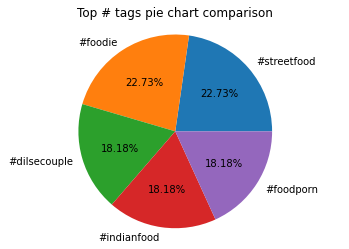

In [22]:
plt.pie(top_5_hash_tags_count, labels = top_5_hash_tags, autopct = '%.2f%%')
plt.axis('equal')
plt.title('Top # tags pie chart comparison')

plt.show()

# |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||